<a href="https://colab.research.google.com/github/dburchill/ML_nano/blob/master/tfds01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install  -q -U tensorflow-datasets
!pip install  -q -U tensorflow-hub

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.2.0
	• tf.keras version: 2.3.0-tf
	• GPU device not found. Running on CPU


In [85]:
(training_set, validation_set, test_set), dataset_info = tfds.load('cats_vs_dogs', split=[
    tfds.core.ReadInstruction('train', to=60, unit='%'),
    tfds.core.ReadInstruction('train', from_=60, to=80, unit='%'),
    tfds.core.ReadInstruction('train', to=-20, unit='%')],
    as_supervised=True,
    with_info=True)
    

In [79]:
dataset_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [86]:
num_classes = dataset_info.features['label'].num_classes
total_num_examples = dataset_info.splits['train'].num_examples

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} images'.format(total_num_examples))

The Dataset has a total of:
• 2 classes
• 23,262 images


In [87]:
class_names = ['cat', 'dog']

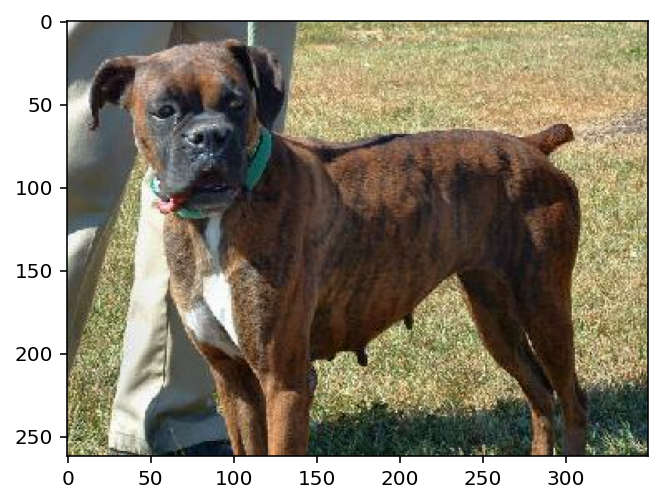

The label of this image is: 1
The class name of this image is: dog


In [89]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label])

In [90]:
batch_size = 32
image_size = 224

num_training_examples = (total_num_examples * train_split) // 100

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

## Transfer Learning with TensorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) is an online repository of pre-trained models. In addition to complete pre-trained models, TensorFlow Hub also contains models without the last classification layer. These models can be used to perform transfer learning by adding a classification layer that suits the number of classes in your particular dataset. You can take a look at all the models available for TensorFlow 2.0 in [TensorFlow Hub](https://tfhub.dev/s?q=tf2-preview).

In this notebook, we will use a network trained on the ImageNet dataset called MobileNet. MobileNet is a state-of-the-art convolutional neural network developed by Google. Convolutional neural networks are out of the scope of this course, but if you want to learn more about them, you can take a look at this [video](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

In the cell below we download the pre-trained MobileNet model without the final classification layer from TensorFlow Hub using the `hub.KerasLayer(URL)` function. This function downloads the desired model form the given TensorFlow Hub `URL` and wraps it in a Keras layer so that we can integrate it in a `tf.keras` Sequential model later. Since this will be the first layer of our Sequential model, we need to specify the `input_shape` parameter. The shape of our input tensor must match the size of the images MobileNet was trained on, namely `(224,224,3)`. 

Our pre-trained model will be responsible for extracting the features of our images, we will therefore call this part of our model the `feature_extractor`.

In [91]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

feature_extractor.trainable = False



In [92]:
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [93]:
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: False
